# _2_01_matcher_patent_census
- Author: Tommy Xie (TommyXie_@outlook.com)
- Nov 2024
- This script prepares training material by selecting the top matches generated by a Vanilla record linkage pipeline

## Notes
March 2025
- Created a version of census (1880) to include those was previously excluded (under-15s)
- Changed save_dirs to eval_dirs for evalutaion. For reproducing the general workflow, just revert it to int_dirs

## To-dos
- Re-run candidate making an comparison on the inve


In [2]:
import pandas as pd
# !pip install recordlinkage
import recordlinkage as rl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from recordlinkage.preprocessing import clean, phonetic
import psutil
# get cpu number
import multiprocessing
try:
    import inspect

except:
    !pip install inspect
    import inspect
def report_ram_usage():
    process = psutil.Process()
    ram_usage = process.memory_info().rss / (1024 ** 2)  # in MB
    # print(f"Current RAM usage: {ram_usage:.2f} MB")
    # human readable GiB
    print(f"Current RAM usage: {ram_usage / 1024:.2f} GiB")

multiprocessing.cpu_count()

# garbage collection
import gc
# gc.collect()

# get RAM
!cat /proc/meminfo

/users/xiet13/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


MemTotal:       32138704 kB
MemFree:        22209604 kB
MemAvailable:   23840776 kB
Buffers:               0 kB
Cached:          1969456 kB
SwapCached:            0 kB
Active:          1426412 kB
Inactive:        8268480 kB
Active(anon):        508 kB
Inactive(anon):  7725632 kB
Active(file):    1425904 kB
Inactive(file):   542848 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               112 kB
Writeback:             0 kB
AnonPages:       7725480 kB
Mapped:           199236 kB
Shmem:               704 kB
KReclaimable:      46476 kB
Slab:              96828 kB
SReclaimable:      46476 kB
SUnreclaim:        50352 kB
KernelStack:        6416 kB
PageTables:        44592 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    16069352 kB
Committed_AS:    7613268 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       14828 kB
VmallocChunk:          0 kB
Percpu:          

In [3]:
!ls -lha ../int_data/sub_patent*

-rw-r--r-- 1 xiet13 cluster-users  21K Aug 21  2024 ../int_data/sub_patents_4o_extrac_fist1200chars_10_docs.pkl
-rw-r--r-- 1 xiet13 cluster-users  15K Aug 21  2024 ../int_data/sub_patents_4o_extrac_fist600chars_10_docs.pkl
-rw-r--r-- 1 xiet13 cluster-users 559K Aug 21  2024 ../int_data/sub_patents_4o_extract.pkl
-rw-r--r-- 1 xiet13 cluster-users 6.1M Aug 28 11:17 ../int_data/sub_patents_4omini_extrac_fist_full_chars_1000_docs.pkl
-rw-r--r-- 1 xiet13 cluster-users 4.2M Aug 29 15:27 ../int_data/sub_patents_4omini_extrac_fist_full_chars_3000_docs.pkl
-rw-r--r-- 1 xiet13 cluster-users 5.1M Sep 13 13:33 ../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_3000_docs.pkl
-rw-r--r-- 1 xiet13 cluster-users 300M Oct 21 23:10 ../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_309035_docs_needs_exp.pkl
-rw-r--r-- 1 xiet13 cluster-users 527M Oct 21 23:57 ../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_309035_docs.pkl


In [3]:
# patent = pd.read_pickle(f'../int_data/sub_patents_4omini_extrac_fist_full_chars_3000_docs.pkl')
# patent = pd.read_pickle(f'../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_3000_docs.pkl')
# patent = pd.read_pickle(f'../int_data/patent_3000_sample_ver_0_2_hisco_alignment.pkl')
patent = pd.read_pickle(f'../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_309035_docs.pkl')


# subset US
patent = patent[(patent.foreign != True)].reset_index(drop = True)

# # make street upper 
# patent.street = patent.street.apply(lambda x:x.upper() if x else x)

# # make capital
# patent['name'] =patent.name.apply(lambda x:x.upper() if x else x)
# patent['pname']=patent.name.apply(lambda x:' '.join(x.split(' ')[:-1]) if x else x)
# patent['sname'] =patent.name.apply(lambda x:x.split(' ')[-1] if x else x)

# assign index
patent = patent.drop_duplicates(subset= ['publicationnumber', 'inventor_no']).set_index(['publicationnumber', 'inventor_no'])
assert patent.index.is_unique
patent

X Publication.date Title  \
publicationnumber inventor_no                                 
US343063A         0            47890       01/06/1886  None   
US343064A         0            47891       01/06/1886  None   
US343065A         0            47892       01/06/1886  None   
US343066A         0            47893       01/06/1886  None   
US343067A         0            47894       01/06/1886  None   
...                              ...              ...   ...   
US215191A         0            50407       06/05/1879  None   
                  1            50407       06/05/1879  None   
                  2            50407       06/05/1879  None   
US215192A         0            50408       06/05/1879  None   
                  1            50408       06/05/1879  None   

                                                                     description  \
publicationnumber inventor_no                                                      
US343063A         0            Application filed November 24, 1885. Serial No...   
US343064A         0            Application filed April 1,1886. Serial No. 197...   
US343065A         0            Application filed April 16, 1886. Serial No. 1...   
US343066A         0            Application filed February 23, 1886. Serial No...   
US343067A         0            Application filed September 4, 1885. Serial No...   
...                                                                          ...   
US215191A         0            N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...   
                  1            N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...   
                  2            N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...   
US215192A         0            Sheets—Sheet 1. G. F. WILSON. Apparatus for Dr...   
                  1            Sheets—Sheet 1. G. F. WILSON. Apparatus for Dr...   

                               year  \
publicationnumber inventor_no         
US343063A         0            1886   
US343064A         0            1886   
US343065A         0            1886   
US343066A         0            1886   
US343067A         0            1886   
...                             ...   
US215191A         0            1879   
                  1            1879   
                  2            1879   
US215192A         0            1879   
                  1            1879   

                                                                     parsed_desc  \
publicationnumber inventor_no                                                      
US343063A         0            {"inventors":[{"name":"Charles F. Plumb","sex"...   
US343064A         0            {"inventors":[{"name":"William F. Price","sex"...   
US343065A         0            {"inventors":[{"name":"Thomas B. Purves","sex"...   
US343066A         0            {"inventors":[{"name":"William D. Ready","sex"...   
US343067A         0            {"inventors":[{"name":"John F. Boeking","sex":...   
...                                                                          ...   
US215191A         0            {"inventors":[{"name":"N. PETERS","sex":0,"occ...   
                  1            {"inventors":[{"name":"N. PETERS","sex":0,"occ...   
                  2            {"inventors":[{"name":"N. PETERS","sex":0,"occ...   
US215192A         0            {"inventors":[{"name":"George F. Wilson","sex"...   
                  1            {"inventors":[{"name":"George F. Wilson","sex"...   

                               prompt_tokens  completion_tokens  total_tokens  \
publicationnumber inventor_no                                                   
US343063A         0                     1037                 67          1104   
US343064A         0                     1035                 73          1108   
US343065A         0                     1033                 78          1111   
US343066A         0                     1022                 65          1087   
US343067A         0                

In [5]:
patent.columns

Index(['X', 'Publication.date', 'Title', 'description', 'year', 'parsed_desc',
       'prompt_tokens', 'completion_tokens', 'total_tokens', 'cost',
       'parsed_desc_parsed', 'parsed_desc_type', 'inventors', 'name', 'sex',
       'occupation', 'industry', 'address', 'street', 'city', 'county',
       'state', 'region', 'foreign', 'full_address', 'fsull_address', 'pname',
       'sname'],
      dtype='object')

In [6]:
patent.name.value_counts()

name
N. PETERS                    12167
THOMAS A. EDISON               540
PETERS                         499
H. PETERS                      349
ELIHU THOMSON                  201
                             ...  
DANIEL W. ROSE                   1
JACOB J. BOYER                   1
RICHARD FRANCIS BRIDEWELL        1
AARON BURGNER                    1
KNIGHT PARKER                    1
Name: count, Length: 169402, dtype: int64

In [7]:
# from dask.distributed import LocalCluster
# cluster = LocalCluster(n_workers=8, threads_per_worker=4)

In [8]:
!ls -lha ../ori_data/US_patent

total 12G
drwxr-xr-x 4 xiet13 cluster-users 6.0K Aug 21  2024 .
drwxr-xr-x 4 xiet13 cluster-users 6.0K Dec 14 23:01 ..
-rw-r--r-- 1 xiet13 cluster-users 5.8M Aug 21  2024 Full_Legend.pdf
drwxr-xr-x 2 xiet13 cluster-users 6.0K Aug 19  2024 .ipynb_checkpoints
-rw-rw---- 1 xiet13 cluster-users 112K Aug  5  2024 Legend.xlsx
drwxr-xr-x 3 xiet13 cluster-users 6.0K Aug  7  2024 __MACOSX
-rw-r--r-- 1 xiet13 cluster-users 1.7G Aug  6  2024 PatentsDataUS_Clean.csv
-rw-r--r-- 1 xiet13 cluster-users 9.6G Aug  5  2024 US_Census1880.dta


In [9]:
# subSample1851 = dd.read_parquet('../Census_samples/Whole_ipum/Whole_1881').compute() # 17,711,030
_1880 = pd.read_parquet('../int_data/US_Census1880.parquet').rename(columns = {'namefrst':'pname', 'namelast':'sname', 'us1880a_street':'street'})

# convert codes to int
_1880.us1880a_city = _1880.us1880a_city.fillna(0)
_1880.us1880a_city = _1880.us1880a_city.astype('int')

# drop those under 15
# _1880 = _1880[_1880['age'] >= 15] # took about 61.84% of the whole population
# Also needs a version without dropping under-15s to do the evaluation

# make recid feature
_1880 = _1880.reset_index().rename(columns = {'index':'recid'}) # don't use dd, as partitions mess with resetting indexes

<Axes: >

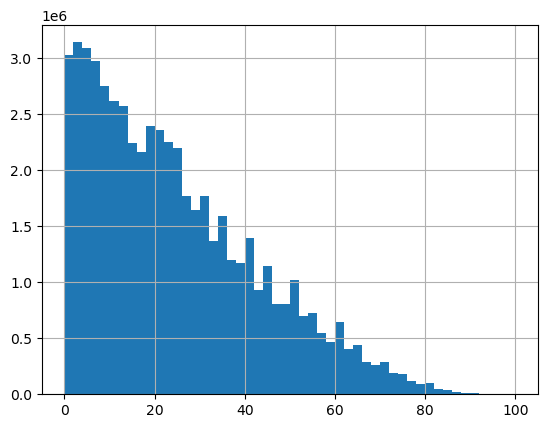

In [10]:
_1880.age.hist(bins = 50)

In [11]:
_1880[_1880.street.str.strip() != ''].head(5)

,recid,pname,sname,sursim,age,sex,occhisco,ind95us,enumdist,countyus,metrous,us1880a_region,us1880a_stateicp,us1880a_city,us1880a_stcounty,us1880a_county,street
43641,43641,WILLIAM G.,BYARS,1.0,54.0,1.0,51020.0,836.0,11,90,0,32.0,41.0,0,10090.0,90.0,WASHINGTON STREET
43642,43642,MARY J.,BYARS,1.0,43.0,2.0,99999.0,0.0,11,90,0,32.0,41.0,0,10090.0,90.0,WASHINGTON STREET
43643,43643,KATTI M.,BYARS,1.0,17.0,2.0,99999.0,0.0,11,90,0,32.0,41.0,0,10090.0,90.0,WASHINGTON STREET
43644,43644,WILLIAM E.,BYARS,1.0,15.0,1.0,99999.0,0.0,11,90,0,32.0,41.0,0,10090.0,90.0,WASHINGTON STREET
43645,43645,MARY A.,BYARS,1.0,13.0,2.0,99999.0,0.0,11,90,0,32.0,41.0,0,10090.0,90.0,WASHINGTON STREET


In [12]:
features = _1880.columns.tolist()
features.pop(0)
features

['pname',
 'sname',
 'sursim',
 'age',
 'sex',
 'occhisco',
 'ind95us',
 'enumdist',
 'countyus',
 'metrous',
 'us1880a_region',
 'us1880a_stateicp',
 'us1880a_city',
 'us1880a_stcounty',
 'us1880a_county',
 'street']

In [13]:
_1880.columns

Index(['recid', 'pname', 'sname', 'sursim', 'age', 'sex', 'occhisco',
       'ind95us', 'enumdist', 'countyus', 'metrous', 'us1880a_region',
       'us1880a_stateicp', 'us1880a_city', 'us1880a_stcounty',
       'us1880a_county', 'street'],
      dtype='object')

In [14]:
_1880

,recid,pname,sname,sursim,age,sex,occhisco,ind95us,enumdist,countyus,metrous,us1880a_region,us1880a_stateicp,us1880a_city,us1880a_stcounty,us1880a_county,street
0,0,JAMES,GREEN,1.0,34.0,1.0,75000.0,439.0,1,10,0,32.0,41.0,0,10010.0,10.0,
1,1,MARY,GREEN,1.0,27.0,2.0,99999.0,0.0,1,10,0,32.0,41.0,0,10010.0,10.0,
2,2,ELLA,GREEN,1.0,11.0,2.0,99999.0,0.0,1,10,0,32.0,41.0,0,10010.0,10.0,
3,3,JESSE,GREEN,1.0,9.0,1.0,99999.0,0.0,1,10,0,32.0,41.0,0,10010.0,10.0,
4,4,FRANK,GREEN,1.0,7.0,1.0,99999.0,0.0,1,10,0,32.0,41.0,0,10010.0,10.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56022515,56022515,LOUIS,MEEKS,1.0,10.0,1.0,NaN,0.0,9999,410,0,NaN,NaN,0,NaN,NaN,
56022516,56022516,MARGARET,MEEKS,1.0,9.0,2.0,NaN,0.0,9999,410,0,NaN,NaN,0,NaN,NaN,
56022517,56022517,SUSAN,MEEKS,1.0,6.0,2.0,NaN,0.0,9999,410,0,NaN,NaN,0,NaN,NaN,
56022518,56022518,MOSES,MEEKS,1.0,0.0,1.0,NaN,0.0,9999,410,0,NaN,NaN,0,NaN,NaN,


In [15]:
# _1880[_1880.recid == 128583]
# _1880.iloc[128583]

In [16]:
import copy

_1880_bak = copy.deepcopy(_1880)

In [17]:
_1880_bak.us1880a_stateicp.isna().sum()

5882038

## Alignment of columns

### Census

In [4]:
import pandas as pd

# # Load the Excel file
# excel_file = pd.ExcelFile("../ori_data/US_patent/Legend.xlsx")
# excel_file.sheet_names # ['US1880a_CITY', 'State_County', 'US1880A_METDIST', 'METROUS']

# city
US1880a_CITY = pd.read_excel("../ori_data/US_patent/Legend.xlsx", sheet_name = "US1880a_CITY")
US1880a_CITY = US1880a_CITY.rename(columns= {col:col.lower() for col in US1880a_CITY.columns.tolist()})
US1880a_CITY.loc[0, 'label'] = None
# clean city of state abbrs
# US1880a_CITY['label_split_size'] = US1880a_CITY.label.apply(lambda x:len(x.split(',')) if x else x) # all 2 -- no problem using the split below
US1880a_CITY.label = US1880a_CITY.label.apply(lambda x:x.split(',')[0] if x else x)

# NOTICE: county is unqiuely identified by ['state', 'county']
State_County = pd.read_excel("../ori_data/US_patent/Legend.xlsx", sheet_name = "State_County")
State_County = State_County.rename(columns= {col:col.lower() for col in State_County.columns.tolist()})
# State_County.notna().sum() # unnamed columns not useful
# State_County.county.nunique(), State_County.state.nunique(), State_County.set_index(['state', 'county']).index.is_unique # 1907, 52, True)


# US1880A_METDIST = pd.read_excel("../ori_data/US_patent/Legend.xlsx", sheet_name = "US1880A_METDIST")
# US1880A_METDIST = US1880A_METDIST.rename(columns= {col:col.lower() for col in US1880A_METDIST.columns.tolist()})
# US1880A_METDIST.loc[0, 'label'] = None
# #  _1880.enumdist.value_counts(), US1880A_METDIST.value_counts() # not the same

# metroUS
METROUS = pd.read_excel("../ori_data/US_patent/Legend.xlsx", sheet_name = "METROUS")
METROUS = METROUS.rename(columns= {col:col.lower() for col in METROUS.columns.tolist()})
METROUS.label = METROUS.label.apply(lambda x:x.split(',')[0] if x else x)
METROUS.loc[0, 'label'] = None

In [19]:
State_County

,state,us1880a_stateicp,us1880a_county,county,unnamed: 4,unnamed: 5,unnamed: 6
0,Alabama,41,10.0,Autauga,NaN,NaN,NaN
1,Alabama,41,30.0,Baldwin,NaN,NaN,NaN
2,Alabama,41,50.0,Barbour,NaN,NaN,NaN
3,Alabama,41,70.0,Bibb,NaN,NaN,NaN
4,Alabama,41,90.0,Blount,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3254,Wyoming,68,430.0,Washakie,NaN,NaN,NaN
3255,Wyoming,68,450.0,Weston,NaN,NaN,NaN
3256,Wyoming,68,455.0,Yellowstone,NaN,NaN,NaN
3257,Wyoming,68,NaN,National Park,NaN,NaN,NaN


In [20]:
# replace codes in census addresses with cleaned strings

# metro
_1880 = pd.merge(left = _1880, right = METROUS, left_on = 'metrous', right_on = 'metrous', how = 'left')
_1880.drop(columns = ['metrous'], inplace = True)
_1880 = _1880.rename(columns = {'label':'metrous'})

# city
_1880 = pd.merge(left = _1880, right = US1880a_CITY, left_on = 'us1880a_city', right_on = 'us1880a_city', how = 'left')
_1880.drop(columns = ['us1880a_city'], inplace = True)
_1880 = _1880.rename(columns = {'label':'us1880a_city'})

# county, and state_by_county. NOTICE: county is unqiuely identified by ['state', 'county']
_1880 = pd.merge(left = _1880, right = State_County[['us1880a_county', 'us1880a_stateicp', 'state','county']], left_on = ['us1880a_county', 'us1880a_stateicp'], right_on = ['us1880a_county', 'us1880a_stateicp'], how = 'left')
# use left join because we want all census reocords to be associated with a county and a state
_1880.drop(columns = ['us1880a_county'], inplace = True)
_1880 = _1880.rename(columns = {'county':'us1880a_county'})

# metdist
# _1880 = pd.merge(left = _1880, right = US1880A_METDIST, left_on = 'us1880a_metdist', right_on = 'us1880a_metdist', how = 'left')

In [21]:
_1880

,recid,pname,sname,sursim,age,sex,occhisco,ind95us,enumdist,countyus,us1880a_region,us1880a_stateicp,us1880a_stcounty,street,metrous,us1880a_city,state,us1880a_county
0,0,JAMES,GREEN,1.0,34.0,1.0,75000.0,439.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
1,1,MARY,GREEN,1.0,27.0,2.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
2,2,ELLA,GREEN,1.0,11.0,2.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
3,3,JESSE,GREEN,1.0,9.0,1.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
4,4,FRANK,GREEN,1.0,7.0,1.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56022515,56022515,LOUIS,MEEKS,1.0,10.0,1.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN
56022516,56022516,MARGARET,MEEKS,1.0,9.0,2.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN
56022517,56022517,SUSAN,MEEKS,1.0,6.0,2.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN
56022518,56022518,MOSES,MEEKS,1.0,0.0,1.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN


In [22]:
State_County.state.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Other'], dtype=object)

In [23]:
_1880.us1880a_stateicp.isna().sum()

5882038

In [24]:
_1880.state.nunique(), _1880.state.unique(), _1880.us1880a_county.nunique(), _1880.us1880a_county.unique()
# _1880.us1880a_stateicp.nunique(), _1880.us1880a_stateicp.unique(), _1880.us1880a_county.nunique(), _1880.us1880a_county.unique()

(48,
 array(['Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
        'Connecticut', 'South Dakota', 'North Dakota', nan, 'Delaware',
        'District of Columbia', 'Florida', 'Georgia', 'Idaho', 'Illinois',
        'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
        'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'Ohio', 'Oregon', 'Pennsylvania', 'Rhode Island',
        'South Carolina', 'Tennessee', 'Texas', 'Utah', 'Vermont',
        'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
       dtype=object),
 1498,
 array(['Autauga', 'Baldwin', 'Bibb', ..., 'Laramie', 'Sweetwater',
        'Uinta'], dtype=object))

In [25]:
_1880

,recid,pname,sname,sursim,age,sex,occhisco,ind95us,enumdist,countyus,us1880a_region,us1880a_stateicp,us1880a_stcounty,street,metrous,us1880a_city,state,us1880a_county
0,0,JAMES,GREEN,1.0,34.0,1.0,75000.0,439.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
1,1,MARY,GREEN,1.0,27.0,2.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
2,2,ELLA,GREEN,1.0,11.0,2.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
3,3,JESSE,GREEN,1.0,9.0,1.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
4,4,FRANK,GREEN,1.0,7.0,1.0,99999.0,0.0,1,10,32.0,41.0,10010.0,,None,None,Alabama,Autauga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56022515,56022515,LOUIS,MEEKS,1.0,10.0,1.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN
56022516,56022516,MARGARET,MEEKS,1.0,9.0,2.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN
56022517,56022517,SUSAN,MEEKS,1.0,6.0,2.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN
56022518,56022518,MOSES,MEEKS,1.0,0.0,1.0,NaN,0.0,9999,410,NaN,NaN,NaN,,None,None,NaN,NaN


In [26]:
# _1880.to_feather('../int_data/_1880_addr_string.feather')

### Patent

#### State
To be used as a blocker

In [27]:
patent.state.value_counts(), patent.state.nunique()

(state
 New York         58830
 Pennsylvania     31726
 Massachusetts    28446
 Illinois         24163
 Ohio             21985
                  ...  
 TX                   1
 C                    1
 0 C                  1
 O C                  1
 NEW HAMPSHIRE        1
 Name: count, Length: 90, dtype: int64,
 90)

In [28]:
_1880.columns
# _1880.state.unique().tolist()

Index(['recid', 'pname', 'sname', 'sursim', 'age', 'sex', 'occhisco',
       'ind95us', 'enumdist', 'countyus', 'us1880a_region', 'us1880a_stateicp',
       'us1880a_stcounty', 'street', 'metrous', 'us1880a_city', 'state',
       'us1880a_county'],
      dtype='object')

In [29]:
_1880.state.unique()

array(['Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
       'Connecticut', 'South Dakota', 'North Dakota', nan, 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'Ohio', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [30]:
len(['Alabama', 'Illinois', 'District of Columbia', 'Maine', 'Michigan',
       'Iowa', 'Missouri', 'New York', 'Ohio', 'Pennsylvania', 'Florida',
       'Texas', 'Wisconsin', 'Kansas', 'Maryland', 'Georgia', 'Indiana',
       'Utah', 'Massachusetts', 'Kentucky', 'Vermont', 'North Carolina',
       'Arizona', 'Arkansas', 'Montana', 'Nebraska', 'Minnesota',
       'Virginia', 'Oregon', 'Nevada', 'New Hampshire', 'Idaho',
       'Rhode Island', 'California', 'New Jersey', 'Mississippi',
       'South Carolina', 'Louisiana', 'Colorado', 'Washington',
       'West Virginia', 'Tennessee', 'Connecticut', 'New Mexico',
       'South Dakota', 'North Dakota', 'Delaware'])

47

In [5]:
# legal 

state_corrections = {
    'D.C.': 'District of Columbia',
    'D. C.': 'District of Columbia',
    'D C': 'District of Columbia',
    'DC': 'District of Columbia',
    'NY': 'New York',
    'N. Y.': 'New York',
    'PA': 'Pennsylvania',
    'INDIANA': 'Indiana',
    'Washington Territory': 'Washington',
    'Dakota': 'North Dakota',  # Assuming North Dakota since it's unclear
    'Dakota Territory': 'North Dakota',  # Similar assumption as Dakota
    'Colorado Territory': 'Colorado',
    'Indian Territory': 'Oklahoma',  # Modern-day Oklahoma
    'Montana Territory': 'Montana',
    'Utah Territory': 'Utah'
}

# Apply the corrections
patent['state'] = patent['state'].replace(state_corrections)

In [32]:
patent.state.value_counts(), patent.state.nunique()

(state
 New York         58830
 Pennsylvania     31726
 Massachusetts    28446
 Illinois         24163
 Ohio             21985
                  ...  
 TX                   1
 C                    1
 0 C                  1
 O C                  1
 NEW HAMPSHIRE        1
 Name: count, Length: 90, dtype: int64,
 90)

#### City (Not aligned)
As an attribute in comparer

In [33]:
patent.city.value_counts(), patent.city.nunique()

(city
 New York         22025
 Washington       15796
 Philadelphia     12354
 Chicago          11068
 Brooklyn         10157
                  ...  
 Avalanche            1
 Thellertown          1
 Swayne County        1
 Mars Bluff           1
 Fagundus City        1
 Name: count, Length: 14176, dtype: int64,
 14176)

In [34]:
_1880.us1880a_city.value_counts(), _1880.us1880a_city.nunique()

(us1880a_city
 New York         1206403
 Philadelphia      847588
 Brooklyn          566641
 Chicago           503489
 Boston            362728
                   ...   
 Columbia           10039
 Ansonia             4345
 Derby               4281
 South Norwalk       3752
 Birmingham          3028
 Name: count, Length: 214, dtype: int64,
 214)

#### Metro (Not aligned) (Patent has not got metro extracted)
As an attribute in comparer

In [35]:
_1880.metrous.value_counts(), _1880.metrous.nunique()

(metrous
 New York-Northeastern NJ            2755281
 Philadelphia                        1177385
 Boston                               884823
 Chicago-Gary-Lake IL                 670664
 Baltimore                            467919
 Cincinnati                           436677
 Pittsburgh-Beaver Valley             393509
 St. Louis                            357019
 San Francisco-Oakland-Vallejo        330930
 Albany-Schenectady-Troy              297873
 New Orleans                          260501
 Providence-Fall River-Pawtuckett     252091
 Worcester                            250402
 Buffalo-Niagara Falls                240712
 Louisville                           223745
 Washington                           222831
 Cleveland                            217444
 New Haven-Meriden                    173203
 Davenport                            166521
 Rochester                            160141
 Milwaukee                            152898
 Syracuse                             129897
 

#### County-State (Not aligned)
As an attribute in comparer

In [6]:
patent.drop_duplicates(subset = ['state','county'])[['state','county']], patent.drop_duplicates(subset = ['state','county']).shape[0]

(                                        state             county
 publicationnumber inventor_no                                   
 US343063A         0                  Michigan            Oakland
 US343064A         0              Pennsylvania            Chester
 US343065A         0                  New York         Rensselaer
 US343066A         0                  New York              Kings
 US343067A         0                  Michigan            Jackson
 ...                                       ...                ...
 US214243A         0            South Carolina  Charleston County
 US214372A         0                      Iowa     Fremont County
 US214619A         0            North Carolina              Green
 US214824A         0                   Indiana          Galveston
 US215025A         0                   Vermont            Vermont
 
 [3753 rows x 2 columns],
 3753)

In [37]:
# state names in patent extraction 
patent.county.value_counts(), patent.county.nunique()

(county
 Cook              10954
 New York          10392
 Kings              9845
 Suffolk            8741
 Philadelphia       7986
                   ...  
 Dear                  1
 Mid Uesex             1
 Waupaca County        1
 Yolano                1
 Moscogee              1
 Name: count, Length: 2339, dtype: int64,
 2339)

In [38]:
# legal state names
_1880.us1880a_county.value_counts(), _1880.us1880a_county.nunique()

(us1880a_county
 New York        1206403
 Philadelphia     847588
 Cook             607940
 Washington       606688
 Kings            599495
                  ...   
 Gaines                8
 Lynn                  8
 Faulk                 4
 Swisher               4
 Randall               3
 Name: count, Length: 1498, dtype: int64,
 1498)

In [7]:
set(patent.state.tolist()) ^ set(_1880.state.tolist()), set(_1880.state.tolist()) ^ set(patent.state.tolist())
# assert set(patent.state.tolist()) | set(_1880.state.tolist()) == set(_1880.state.tolist())

NameError: name '_1880' is not defined

### Feature engineering: names (experimental)

In [40]:
# # fillna in names before phonetic
# patent.sname.value_counts()
# patent.sname = patent.sname.fillna('UNKNOWN')
# patent.sname.value_counts()

In [ ]:
# # phonetic encoding pnames and surnames
# # 
# from recordlinkage.preprocessing import clean, phonetic
# # get name 
# # pname: Possibly "Personal Name" or "Given Name", referring to the individual's first name.
# # oname: Toname could potentially stand for "Other Name," which might include middle names, initials, or other identifiers. 
# # It could also be a field where various types of data have been entered, possibly due to data collection methods or data quality issues.
# # sname: This is generally understood to mean "Surname" or "Family Name", which is the individual's last name.

# name_cols = ['pname', 'sname']
# methods = ['soundex', 'metaphone']
# # age_cols = ['uk1861a_age']

# def phonetic_names(df, cols, methods = ['soundex', 'metaphone']):
#     # clean
#     for col in cols:
#         print(f"cleaning col {col}")
#         df[col] = clean(df[col], lowercase=False, remove_brackets=False)

#     # phonetic
#     for method in methods:
#         print(f"doing {method} for col {col}")
#         for col in cols:
#             df[f'{col}_{method}'] = phonetic(df[col], method = method)

#     return df
    
# _1880 = phonetic_names(_1880, name_cols)
# # patent = phonetic_names(patent, name_cols)

cleaning col pname
cleaning col sname
doing soundex for col sname


In [8]:
from recordlinkage.preprocessing import clean, phonetic

def phonetic_names_optimized(df, cols, methods=['soundex', 'metaphone']):
    # Clean the columns first
    for col in cols:
        print(f"Cleaning column: {col}")
        df[col] = clean(df[col], lowercase=False, remove_brackets=False).astype(str)
    
    # For each method and each column, compute the phonetic code only for unique values
    for method in methods:
        for col in cols:
            print(f"Applying {method} for column: {col}")
            unique_vals = df[col].unique()  
            # Create a mapping from original value to its phonetic encoding
            mapping = {val: phonetic(pd.Series([val]), method=method).iloc[0] for val in unique_vals} # When you call phonetic(pd.Series([val]), method=method), you're passing a one-element Series.
            df[f'{col}_{method}'] = df[col].map(mapping)
    
    return df

# Example usage:
name_cols = ['pname', 'sname']
# _1880 = phonetic_names_optimized(_1880, name_cols)
patent = phonetic_names_optimized(patent, name_cols)

Cleaning column: pname
Cleaning column: sname
Applying soundex for column: pname
Applying soundex for column: sname
Applying metaphone for column: pname
Applying metaphone for column: sname


In [14]:
patent.columns

Index(['X', 'Publication.date', 'Title', 'description', 'year', 'parsed_desc',
       'prompt_tokens', 'completion_tokens', 'total_tokens', 'cost',
       'parsed_desc_parsed', 'parsed_desc_type', 'inventors', 'name', 'sex',
       'occupation', 'industry', 'address', 'street', 'city', 'county',
       'state', 'region', 'foreign', 'full_address', 'fsull_address', 'pname',
       'sname', 'county_state'],
      dtype='object')

In [42]:
# _1880.pname_soundex.nunique(), _1880.sname_soundex.nunique(), patent.pname_soundex.nunique(),  patent.sname_soundex.nunique(), 

In [9]:
# -county-state
# _1880['county_state'] = _1880.apply(lambda x:str(x.us1880a_county) + ', ' + str(x.state), axis = 1)
# patent['county_state'] = patent.apply(lambda x:str(x.county) + ', ' + str(x.state), axis = 1)

# _1880['county_state'] = _1880['us1880a_county'].astype(str) + ', ' + _1880['state'].astype(str)
patent['county_state'] = patent['county'].astype(str) + ', ' + patent['state'].astype(str)


In [13]:
# _1880.to_parquet('../int_data/US_Census1880_features_alinged.parquet')
# _1880.to_parquet('../eval_data/US_Census1880_features_alinged.parquet')

# the two below are almost identical (except for names)
# patent.to_csv('../int_data/US_patent_features_aligned.csv') # publication number is index
patent.to_csv('../eval_data/US_patent_features_aligned.csv')

In [14]:
patent

X Publication.date Title  \
publicationnumber inventor_no                                 
US343063A         0            47890       01/06/1886  None   
US343064A         0            47891       01/06/1886  None   
US343065A         0            47892       01/06/1886  None   
US343066A         0            47893       01/06/1886  None   
US343067A         0            47894       01/06/1886  None   
...                              ...              ...   ...   
US215191A         0            50407       06/05/1879  None   
                  1            50407       06/05/1879  None   
                  2            50407       06/05/1879  None   
US215192A         0            50408       06/05/1879  None   
                  1            50408       06/05/1879  None   

                                                                     description  \
publicationnumber inventor_no                                                      
US343063A         0            Application filed November 24, 1885. Serial No...   
US343064A         0            Application filed April 1,1886. Serial No. 197...   
US343065A         0            Application filed April 16, 1886. Serial No. 1...   
US343066A         0            Application filed February 23, 1886. Serial No...   
US343067A         0            Application filed September 4, 1885. Serial No...   
...                                                                          ...   
US215191A         0            N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...   
                  1            N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...   
                  2            N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...   
US215192A         0            Sheets—Sheet 1. G. F. WILSON. Apparatus for Dr...   
                  1            Sheets—Sheet 1. G. F. WILSON. Apparatus for Dr...   

                               year  \
publicationnumber inventor_no         
US343063A         0            1886   
US343064A         0            1886   
US343065A         0            1886   
US343066A         0            1886   
US343067A         0            1886   
...                             ...   
US215191A         0            1879   
                  1            1879   
                  2            1879   
US215192A         0            1879   
                  1            1879   

                                                                     parsed_desc  \
publicationnumber inventor_no                                                      
US343063A         0            {"inventors":[{"name":"Charles F. Plumb","sex"...   
US343064A         0            {"inventors":[{"name":"William F. Price","sex"...   
US343065A         0            {"inventors":[{"name":"Thomas B. Purves","sex"...   
US343066A         0            {"inventors":[{"name":"William D. Ready","sex"...   
US343067A         0            {"inventors":[{"name":"John F. Boeking","sex":...   
...                                                                          ...   
US215191A         0            {"inventors":[{"name":"N. PETERS","sex":0,"occ...   
                  1            {"inventors":[{"name":"N. PETERS","sex":0,"occ...   
                  2            {"inventors":[{"name":"N. PETERS","sex":0,"occ...   
US215192A         0            {"inventors":[{"name":"George F. Wilson","sex"...   
                  1            {"inventors":[{"name":"George F. Wilson","sex"...   

                               prompt_tokens  completion_tokens  total_tokens  \
publicationnumber inventor_no                                                   
US343063A         0                     1037                 67          1104   
US343064A         0                     1035                 73          1108   
US343065A         0                     1033                 78          1111   
US343066A         0                     1022                 65          1087   
US343067A         0                

### (Deprecated) Feature Engineering Occupations - HISCO
Agreed with Filippo and Olmo that we don't use occupation in feature for learning as it will be loopy

In [ ]:
stopper # Agreed with Filippo and Olmo that we don't use occupation in feature for learning as it will be loopy

In [ ]:
# # get occupation similarity, instead of hard hisco number match (resulted in 0 matches when we had 1420 rows)
# # turn census hisco code into desc using the table in occanine model 
# try:
#     from histocc import OccCANINE # HISCO prediciton class
# except:
#     !rm -rf OccCANINE # Remove existing
#     !git clone https://github.com/christianvedels/OccCANINE
#     !pip install OccCANINE/
#     !pip install unidecode
#     from histocc import OccCANINE # HISCO prediciton class
# model = OccCANINE() # This downloads and initializes the model from HuggingFace
# hisco_table = {k:v for (k,v) in zip(model.key.values(), model.key_desc.values())}
# import pickle
# with open('../int_data/hisco_table_dict.pkl', 'wb') as f:
#     pickle.dump(hisco_table, f)

In [4]:
import pickle
with open('../int_data/hisco_table_dict.pkl', 'rb') as f:
    hisco_table = pickle.load(f)
hisco_table = pd.DataFrame.from_dict(hisco_table, orient = 'index').reset_index().rename(columns = {'index':'ori_hisco_code', 0:'ori_hisco_text'})

In [6]:
# merge _1880 with hisco_table on 'occhisco' and 'ori_code'
_1880 = pd.merge(left = _1880, right = hisco_table, left_on = 'occhisco', right_on = 'ori_hisco_code', how = 'left') # we want to keep the whole rows on the census side

In [7]:
dist = pd.read_csv('../final_data/long_table_29677.csv')
dist.occ_i = dist.occ_i.apply(lambda x:x.replace('HISCO', ''))
dist.occ_j = dist.occ_j.apply(lambda x:x.replace('HISCO', ''))
dist.Value.min(), dist.Value.max() # Cosine similarity has range (-1, 1), but we don't have any negative values here

(0.0141010388126036, 0.2124531245710798)

In [8]:
dist.occ_i.max(), max(hisco_table.keys())

('999', 'ori_hisco_text')

In [9]:
dist.occ_i.nunique(), len(hisco_table.keys()), len(set(dist.occ_i.tolist()) - set(hisco_table.keys())) # hisco code in dist should be a subset of that in hisco_table

(244, 2, 244)

In [10]:
_1880.columns

Index(['recid', 'pname', 'sname', 'sursim', 'age', 'sex', 'occhisco',
       'ind95us', 'enumdist', 'countyus', 'us1880a_region', 'us1880a_stateicp',
       'us1880a_stcounty', 'street', 'metrous', 'us1880a_city', 'state',
       'us1880a_county', 'county_state', 'ori_hisco_code', 'ori_hisco_text'],
      dtype='object')

In [15]:
# alignment 
'''In most of the cases, it should corresponds to the first 3 digits of the standard classification. Maybe in all cases? I don’t remember. 
I remember I did something to create homogeneous groups at more aggregate levels, but I am not sure if I did anything at the 3-digit level.
Anyway, you can rely on this crosswalk table.
'''
# import pandas as pd
# # read hisco table
# cross_walk_table = pd.read_csv('../aux_data/HISCO_tree3.csv')
# cross_walk_table
_1880['_3_dig_code'] = _1880['ori_hisco_code'].apply(lambda x:str(x)[:3]).replace('nan', None)
patent['_3_dig_code'] = patent['hisco'].apply(lambda x:str(x)[:3]).replace('nan', None)

KeyError: 'hisco'

In [16]:
patent

,X,Publication.date,Title,description,year,parsed_desc,prompt_tokens,completion_tokens,total_tokens,cost,...,city,county,state,region,foreign,full_address,fsull_address,pname,sname,county_state
0,47890,01/06/1886,NaN,"Application filed November 24, 1885. Serial No...",1886,"{""inventors"":[{""name"":""Charles F. Plumb"",""sex""...",1037,67,1104,0.000196,...,Waterford,Oakland,Michigan,NaN,False,"Waterford, Oakland, Michigan","Waterford, Oakland, Michigan",CHARLES F.,PLUMB,"Oakland, Michigan"
1,47891,01/06/1886,NaN,"Application filed April 1,1886. Serial No. 197...",1886,"{""inventors"":[{""name"":""William F. Price"",""sex""...",1035,73,1108,0.000199,...,West Caln township,Chester,Pennsylvania,NaN,False,"West Caln township, Chester County, Pennsylvania","West Caln township, Chester County, Pennsylvania",WILLIAM F.,PRICE,"Chester, Pennsylvania"
2,47892,01/06/1886,NaN,"Application filed April 16, 1886. Serial No. 1...",1886,"{""inventors"":[{""name"":""Thomas B. Purves"",""sex""...",1033,78,1111,0.000202,...,Greenbush,Rensselaer,New York,NaN,False,"Greenbush, Rensselaer, New York","Greenbush, Rensselaer, New York",THOMAS B.,PURVES,"Rensselaer, New York"
3,47893,01/06/1886,NaN,"Application filed February 23, 1886. Serial No...",1886,"{""inventors"":[{""name"":""William D. Ready"",""sex""...",1022,65,1087,0.000192,...,South Brooklyn,Kings,New York,NaN,False,"South Brooklyn, Kings, New York","South Brooklyn, Kings, New York",WILLIAM D.,READY,"Kings, New York"
4,47894,01/06/1886,NaN,"Application filed September 4, 1885. Serial No...",1886,"{""inventors"":[{""name"":""John F. Boeking"",""sex"":...",1036,61,1097,0.000192,...,Jackson,Jackson,Michigan,NaN,False,"Jackson, Jackson, Michigan","Jackson, Jackson, Michigan",JOHN F.,BOEKING,"Jackson, Michigan"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348608,50407,06/05/1879,NaN,"N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...",1879,"{""inventors"":[{""name"":""N. PETERS"",""sex"":0,""occ...",1096,187,1283,0.000277,...,Washington,NaN,District of Columbia,NaN,False,"Washington, D C","Washington, D C",N.,PETERS,"None, District of Columbia"
348609,50407,06/05/1879,NaN,"N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...",1879,"{""inventors"":[{""name"":""N. PETERS"",""sex"":0,""occ...",1096,187,1283,0.000277,...,East Providence,NaN,Rhode Island,NaN,False,"East Providence, Rhode Island","East Providence, Rhode Island",GEORGE F.,WILSON,"None, Rhode Island"
348610,50407,06/05/1879,NaN,"N. PETERS. PHOTO-LITHOGRAPHER. WASHINGTON, 0 C...",1879,"{""inventors"":[{""name"":""N. PETERS"",""sex"":0,""occ...",1096,187,1283,0.000277,...,Providence,NaN,Rhode Island,NaN,False,"Providence, Rhode Island","Providence, Rhode Island",CHARLES A.,CATLIN,"None, Rhode Island"
348611,50408,06/05/1879,NaN,Sheets—Sheet 1. G. F. WILSON. Apparatus for Dr...,1879,"{""inventors"":[{""name"":""George F. Wilson"",""sex""...",1085,121,1206,0.000235,...,East Providence,Providence,Rhode Island,NaN,False,"East Providence, Rhode Island","East Providence, Rhode Island",GEORGE F.,WILSON,"Providence, Rhode Island"


In [ ]:
set(patent['_3_dig_code'].unique())- set(_1880['_3_dig_code'].unique()), set(_1880['_3_dig_code'].unique()) - set(patent['_3_dig_code'].unique())

In [ ]:
stopper # Agreed with Filippo and Olmo that we don't use occupation in feature for learning as it will be loopy

## RL make candidates

*********************************************************
Temporary Reading. Can be deleted. Please do so if splitting the script into smaller snippets

In [3]:
_1880= pd.read_parquet('../eval_data/US_Census1880_features_alinged.parquet')
patent =pd.read_csv('../eval_data/US_patent_features_aligned.csv')

*********************************************************

In [4]:
import psutil
# Function to report RAM usage
def report_ram_usage():
    process = psutil.Process()
    ram_usage = process.memory_info().rss / (1024 ** 2)  # in MB
    # print(f"Current RAM usage: {ram_usage:.2f} MB")
    # human readable GiB
    print(f"Current RAM usage: {ram_usage / 1024:.2f} GiB")

# Report RAM before starting
report_ram_usage()

Current RAM usage: 10.62 GiB


In [5]:
## Create index for census
_1880 = _1880.drop_duplicates(subset= ['recid']).reset_index(drop = True).set_index(['recid'])
_1880

,pname,sname,sursim,age,sex,occhisco,ind95us,enumdist,countyus,us1880a_region,...,street,metrous,us1880a_city,state,us1880a_county,county_state,pname_soundex,sname_soundex,pname_metaphone,sname_metaphone
recid,,,,,,,,,,,,,,,,,,,,,
0,JAMES,GREEN,1.0,34.0,1.0,75000.0,439.0,1,10,32.0,...,,None,None,Alabama,Autauga,"Autauga, Alabama",J520,G650,JMS,KRN
1,MARY,GREEN,1.0,27.0,2.0,99999.0,0.0,1,10,32.0,...,,None,None,Alabama,Autauga,"Autauga, Alabama",M600,G650,MR,KRN
2,ELLA,GREEN,1.0,11.0,2.0,99999.0,0.0,1,10,32.0,...,,None,None,Alabama,Autauga,"Autauga, Alabama",E400,G650,EL,KRN
3,JESSE,GREEN,1.0,9.0,1.0,99999.0,0.0,1,10,32.0,...,,None,None,Alabama,Autauga,"Autauga, Alabama",J200,G650,JS,KRN
4,FRANK,GREEN,1.0,7.0,1.0,99999.0,0.0,1,10,32.0,...,,None,None,Alabama,Autauga,"Autauga, Alabama",F652,G650,FRNK,KRN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56022515,LOUIS,MEEKS,1.0,10.0,1.0,NaN,0.0,9999,410,NaN,...,,None,None,None,None,"nan, nan",L200,M200,LS,MKS
56022516,MARGARET,MEEKS,1.0,9.0,2.0,NaN,0.0,9999,410,NaN,...,,None,None,None,None,"nan, nan",M626,M200,MRKRT,MKS
56022517,SUSAN,MEEKS,1.0,6.0,2.0,NaN,0.0,9999,410,NaN,...,,None,None,None,None,"nan, nan",S250,M200,SSN,MKS


In [6]:
_1880.index = _1880.index.astype('str')
patent.index = patent.index.astype('str')

In [7]:
# _1880.state.isna().sum(), _1880_bak.us1880a_stateicp.isna().sum(), patent.state.isna().sum() # So there are orinally these null values in states, around 10%
_1880.state.isna().sum(), patent.state.isna().sum() # So there are orinally these null values in states, around 10%

(5882238, 46882)

In [8]:
# fill nas for blocking columns: state strings
_1880.state = _1880.state.fillna('nan')
patent.state = patent.state.fillna('nan')

In [9]:
_1880.state.value_counts(), patent.state.value_counts()

(state
 nan                     5882238
 New York                5079061
 Pennsylvania            4287823
 Ohio                    3198167
 Illinois                3080787
 Missouri                2141601
 Indiana                 1977734
 Massachusetts           1784225
 Kentucky                1648010
 Michigan                1636807
 Iowa                    1624537
 Texas                   1594781
 Tennessee               1544200
 Georgia                 1543614
 Virginia                1509825
 North Carolina          1401478
 Wisconsin               1316850
 Alabama                 1264230
 Mississippi             1133628
 New Jersey              1131648
 South Carolina           996544
 Kansas                   995693
 Louisiana                940786
 Maryland                 935894
 California               862986
 Arkansas                 802539
 Minnesota                781225
 Maine                    648668
 Connecticut              623548
 West Virginia            618951
 Ne

In [10]:
_1880.sname_soundex.isna().sum(), patent.sname_soundex.isna().sum(), patent.sname.isna().sum()

(0, 42, 8003)

In [11]:
_1880.columns

Index(['pname', 'sname', 'sursim', 'age', 'sex', 'occhisco', 'ind95us',
       'enumdist', 'countyus', 'us1880a_region', 'us1880a_stateicp',
       'us1880a_stcounty', 'street', 'metrous', 'us1880a_city', 'state',
       'us1880a_county', 'county_state', 'pname_soundex', 'sname_soundex',
       'pname_metaphone', 'sname_metaphone'],
      dtype='object')

In [12]:

import recordlinkage as rl
import tqdm
# import  SortedNeighbourhoodIndex
from recordlinkage.index import SortedNeighbourhood
# initalise an index
indexer = rl.Index()


blocking_columns = ['state', 'sname_soundex'] 
# blocking_columns = ['state'] 
# State: assumption: The inventor don't move and are still alive in the same state within certain timeframe (e.g. 10 years)

SortedNeighbourhood_columns = ['sname_soundex']
# Why 'sname'?: It's one word, while middle name and first time might be simultaneously present in pname.

# patent_aut.name_soundex.nunique() # 4045

# We are about to make the candidates which only needs the index and the blocking_columns, so we subset columns
patent_col_subset = patent[blocking_columns]
_1880_col_subset = _1880[blocking_columns]

########################################
del patent 
del _1880
########################################


# indexer.block(left_on=blocking_columns, right_on=blocking_columns)
indexer.add(SortedNeighbourhood(left_on=SortedNeighbourhood_columns, right_on=SortedNeighbourhood_columns, window=3))
candidates = indexer.index(patent_col_subset, _1880_col_subset)

MemoryError: Unable to allocate 41.0 GiB for an array with shape (5506256476,) and data type int64

In [ ]:
report_ram_usage()

In [ ]:
candidates

In [ ]:
import pickle

# Open a binary file and save the object using pickle
# with open("../int_data/cands.pkl", "wb") as f:
# with open("../int_data/cands_hyb.pkl", "wb") as f:
# with open("../int_data/cands_phonetic.pkl", "wb") as f:
# with open("../int_data/cands_ver_0_2_phonetic.pkl", "wb") as f:
# with open("../int_data/all_patent_cands_ver_0_2_phonetic.pkl", "wb") as f:
with open("../eval_data/all_patent_cands_ver_0_2_phonetic.pkl", "wb") as f:
    pickle.dump(candidates, f)

In [ ]:
import pickle

# Open a binary file and save the object using pickle
# with open("../int_data/cands.pkl", "rb") as f:
# with open("../int_data/cands_hyb.pkl", "rb") as f:
# with open("../int_data/cands_phonetic.pkl", "rb") as f:
# with open("../int_data/cands_ver_0_2_phonetic.pkl", "rb") as f:
# with open("../int_data/all_patent_cands_ver_0_2_phonetic.pkl", "rb") as f:
with open("../eval_data/all_patent_cands_ver_0_2_phonetic.pkl", "rb") as f:
    candidates = pickle.load(f)

## Compare

In [ ]:
# # temporarily saving _1880, patent and dist
import os
# os.makedirs('../int_data/temp', exist_ok = True)
# _1880.to_pickle('../int_data/temp/_1880.pkl')
# patent.to_pickle('../int_data/temp/patent.pkl')

os.makedirs('../eval_data/temp', exist_ok = True)
_1880.to_pickle('../eval_data/temp/_1880.pkl')
patent.to_pickle('../eval_data/temp/patent.pkl')

In [ ]:
import pandas as pd
_1880 = pd.read_pickle('../eval_data/temp/_1880.pkl')
patent = pd.read_pickle('../eval_data/temp/patent.pkl')

In [ ]:
_1880.isna().sum()

In [ ]:
# from Utils.hisco_sim import HiscoSimilarity  # Ensure Utils is on the correct path
# import recordlinkage as rl
# import pandas as pd

# dist = pd.read_csv('../final_data/long_table_29677.csv')
# dist.occ_i = dist.occ_i.apply(lambda x:x.replace('HISCO', ''))
# dist.occ_j = dist.occ_j.apply(lambda x:x.replace('HISCO', ''))
# dist.Value.min(), dist.Value.max() # Cosine similarity has range (-1, 1), but we don't have any negative values here

# # Initialize the comparer
# print("Initializing comparer...")
# comparer = rl.Compare()

# HISCO_CODE_PATENT_NAME = '_3_dig_code'
# HISCO_DESC_PATENT_NAME = 'desc'
# HISCO_CODE_CENSUS_NAME = '_3_dig_code'
# HISCO_DESC_CENSUS_NAME = 'ori_hisco_text'

# str_methods = {
#     ('pname', 'pname'): 'jarowinkler',
#     ('sname', 'sname'): 'jarowinkler',
#     ('county_state', 'county_state'): 'levenshtein',
#     ('city', 'metrous'): 'levenshtein',
#     ('city', 'us1880a_city'): 'levenshtein',
#     (HISCO_DESC_PATENT_NAME, HISCO_DESC_CENSUS_NAME): 'levenshtein'
# }

# # Add string comparison features
# for (attr1, attr2), method in str_methods.items():
#     comparer.string(attr1, attr2, method=method, label=f'{attr1}_{attr2}_{method}')

# # Initialize HiscoSimilarity and add it to comparer
# sim_comparer = HiscoSimilarity(
#     left_on=HISCO_CODE_PATENT_NAME,
#     right_on=HISCO_CODE_CENSUS_NAME,
#     hisco_sim_table=dist,
#     label='occ_similarity_HISCO'
# )
# print(sim_comparer)
# comparer.add(sim_comparer)

# # Assuming `candidates`, `patent`, and `_1880` are correctly defined in the notebook
# partition_result = comparer.compute(candidates[:4], patent, _1880)

# partition_result


In [ ]:
patent.columns, _1880.columns, 

In [ ]:
'metro' in patent.columns, 'metrous' in _1880.columns, 

In [ ]:
from Utils.hisco_sim import *

print("Initializing comparer...")
# comparer = rl.Compare(n_jobs = -1)  # Utilizing all available CPUs
comparer = rl.Compare()

# str_methods = {
#     'pname': 'jarowinkler',
#     'sname': 'jarowinkler',
#     # 'name_metaphone': 'jarowinkler',
#     # 'street': 'levenshtein',     # 'street': 'levenshtein' # only less than 1 % was larger than 0, therefore abandoned
#     'metrous': 'levenshtein',
#     'city': 'levenshtein',
#     'metrous': 'levenshtein',
# }

HISCO_CODE_PATENT_NAME = '_3_dig_code'
HISCO_DESC_PATENT_NAME = 'desc'
HISCO_CODE_CENSUS_NAME = '_3_dig_code'
HISCO_DESC_CENSUS_NAME = 'ori_hisco_text'

str_methods = {
    ('pname', 'pname'): 'jarowinkler',
    ('sname', 'sname'): 'jarowinkler',
    # 'name_metaphone': 'jarowinkler',
    # 'street': 'levenshtein',     # 'street': 'levenshtein' # only less than 1 % was larger than 0, therefore abandoned
    ('county_state', 'county_state'): 'levenshtein',
    ('city','metrous'): 'levenshtein',
    # ('metro','metrous'): 'levenshtein',
    ('city', 'us1880a_city'): 'levenshtein', # TODO: This confusion can be solved by proviidng a metro column in patent extraction
    # (HISCO_DESC_PATENT_NAME, HISCO_DESC_CENSUS_NAME): 'levenshtein'
}

features = str_methods.keys()
for (attr1, attr2), method in str_methods.items():
    comparer.string(attr1, attr2, method=method, label=f'{attr1}_{attr2}_{method}')

# sim_comparer = HiscoSimilarity(left_on = HISCO_CODE_PATENT_NAME, right_on = HISCO_CODE_CENSUS_NAME, hisco_sim_table = dist, label='occ_similarity_HISCO')
# # sim_comparer = HiscoSimilarity(left_on = HISCO_CODE_PATENT_NAME, right_on = HISCO_CODE_CENSUS_NAME, hisco_sim_table = dist)
# # print(sim_comparer)
# comparer.add(sim_comparer)


# partition_result = comparer.compute(candidates, patent, _1880)
# partition_result

In [ ]:
!cat /proc/meminfo

In [ ]:
# Batch-processing
import os
from tqdm import tqdm
# BATCH_SIZE = 30
BATCH_SIZE = 30_000_000
OUTPUT_DIR = "../int_data/batch_processed"
# starting_index = 0 # So we can start from where we stopped
starting_index = 0
os.makedirs(OUTPUT_DIR, exist_ok = True)
    
for i in range(starting_index, len(candidates), BATCH_SIZE):
    batch = candidates[i:i + BATCH_SIZE]
    print(f"processing {i}, {i+BATCH_SIZE}")
    batch = comparer.compute(batch, patent, _1880)
    batch.to_pickle(f"{OUTPUT_DIR}/batch_{i}_{i+BATCH_SIZE}.pickle")
    print(f"saved {i}, {i+BATCH_SIZE}")

print("Batch processing complete and data saved.")

In [ ]:
len(candidates)

In [ ]:
# import os
# import pandas as pd
# base_path = "../int_data/batch_processed/"
# batch_files = []
# for file in os.listdir(base_path):
#     full_path = base_path + file
#     # print(full_path)
#     batch = pd.read_pickle(full_path)
#     batch_files.append(batch)
# partition_result = pd.concat(batch_files, axis = 0)
# partition_result
# # Too long and memory hungry

In [ ]:
# Trying Dask
import dask.dataframe as dd
import pandas as pd
import pickle
import os

from dask.distributed import Client
client = Client()  # Starts a local cluster

base_path = "../int_data/batch_processed/"
pickle_files = [f for f in os.listdir(base_path) if f.endswith('.pickle')]

# Initialize an empty list to hold the Dask DataFrame partitions
dask_df_list = []

# Iterate over each pickle file, load it, and append to Dask DataFrame
for file in pickle_files:
    with open(os.path.join(base_path, file), 'rb') as f:
        df = pickle.load(f)
        dask_df_list.append(dd.from_pandas(df.reset_index(), npartitions=1))

# Concatenate all the Dask DataFrame partitions without loading everything into memory
ddf = dd.concat(dask_df_list)

# Save the concatenated Dask DataFrame as a Parquet file
ddf.to_parquet('../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.parquet', compression='snappy')

# Save the Dask DataFrame to CSV
ddf.to_csv('../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.csv', single_file=True)


In [ ]:
# import pickle

# Open a binary file and save the object using pickle
# with open("../int_data/compare_pool_pkl", "wb") as f:
# with open("../int_data/compare_pool_phonetic.pkl", "wb") as f:
# with open("../int_data/compare_pool_ver_0_2_phonetic.pkl", "wb") as f:
# with open("../int_data/compare_pool_ver_0_2_phonetic_correct.pkl", "wb") as f:
# with open("../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.pkl", "wb") as f:
#     pickle.dump(partition_result, f)
# Open a binary file and save the object using pickle
# with open("../int_data/compare_pool.pkl", "rb") as f:
# with open("../int_data/compare_pool_phonetic.pkl", "rb") as f:
# with open("../int_data/compare_pool_ver_0_2_phonetic.pkl", "rb") as f:
# with open("../int_data/compare_pool_ver_0_2_phonetic_correct.pkl", "rb") as f:
# with open("../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.pkl", "rb") as f:

#     partition_result = pickle.load(f)
# partition_result

In [ ]:
!ls -lha ../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.parquet ../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.csv

In [ ]:
import pandas as pd
import dask.dataframe as dd

def safe_first_element(x):
    if isinstance(x, list) and x and pd.notna(x[0]):
        return x[0]
    return None

def get_three_level_idx(partition_result): # outdated, try str.extract() with re, or ast.literal_eval()
    # Reset index with names patent_idx and census_idx
    partition_result = partition_result.reset_index().rename(columns={'level_0': 'patent_idx', 'level_1': 'recid'})

    # Check if partition_result is a Dask DataFrame
    if isinstance(partition_result, dd.core.DataFrame):
        # Use Dask-specific operations with meta provided
        partition_result['patent_id'] = partition_result['patent_idx'].apply(lambda x: eval(x)[0], meta=('patent_id', 'object'))
        partition_result['patent_count'] = partition_result['patent_idx'].apply(lambda x: eval(x)[1], meta=('patent_count', 'object'))
    else:
        # Assume partition_result is a Pandas DataFrame
        partition_result['patent_id'] = partition_result['patent_idx'].apply(lambda x: eval(x)[0])
        partition_result['patent_count'] = partition_result['patent_idx'].apply(lambda x: eval(x)[1])

    # Drop the 'patent_idx' column after extracting patent_id and patent_count
    partition_result = partition_result.drop(columns=['patent_idx'])

    # Set a new multi-level index if it is a Pandas DataFrame
    if not isinstance(partition_result, dd.core.DataFrame):
        partition_result = partition_result.set_index(['patent_id', 'patent_count', 'recid'])

    return partition_result


In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import sqlite3
import os
import time
import gc
import cProfile
import pstats
import concurrent.futures
import queue
import threading
from memory_profiler import memory_usage

# Define a global connection string to SQLite since sqlite3 doesn't handle concurrent connections well
sqlite_file_path = '../int_data/comparison_pool_all.db'

# Define a queue to store data for writing
write_queue = queue.Queue()

# Function to write to SQLite from the queue
def writer():
    conn = sqlite3.connect(sqlite_file_path)
    while True:
        data = write_queue.get()
        if data is None:
            break  # Exit signal
        try:
            # Ensure table exists with correct schema before inserting
            with conn:
                create_table_query = '''
                CREATE TABLE IF NOT EXISTS comparison_pool_all (
                    patent_idx TEXT,
                    recid TEXT,
                    pname_pname_jarowinkler REAL,
                    sname_sname_jarowinkler REAL,
                    county_state_county_state_levenshtein REAL,
                    city_metrous_levenshtein REAL,
                    city_us1880a_city_levenshtein REAL,
                    city_metro_level_l_score REAL
                );
                '''
                conn.execute(create_table_query)

            data.to_sql('comparison_pool_all', conn, if_exists='append', index=False)
            print("Data written to SQLite.")
        except sqlite3.OperationalError as e:
            if "database is locked" in str(e):
                print("Database is locked. Retrying...")
                # Optionally, implement retry logic here
            else:
                raise e
        finally:
            write_queue.task_done()
    conn.close()

# Start the writer thread
writer_thread = threading.Thread(target=writer, daemon=True)
writer_thread.start()

# Function to track memory usage and time for each step
def process_parquet_file(file_path):
    try:
        start_time = time.time()

        # Track the memory usage
        mem_usage_before = memory_usage()[0]

        # Load individual Parquet file using PyArrow
        parquet_file = pq.read_table(file_path)
        row_group = parquet_file.to_pandas()
        print(f"Loaded file {file_path} into DataFrame")

        # Profiling memory after loading
        mem_usage_after = memory_usage()[0]
        print(f"Memory used for loading file {file_path}: {mem_usage_after - mem_usage_before} MiB")

        # Rename columns if necessary
        row_group.rename(columns={'level_0': 'patent_idx', 'level_1': 'recid'}, inplace=True)

        # Apply the transformations
        row_group['city_metro_level_l_score'] = (
            row_group['city_metrous_levenshtein'] + row_group['city_us1880a_city_levenshtein']
        ) / 2

        # Impute zeros using `where` instead of `apply()`
        row_group['city_metro_level_l_score'] = row_group['city_metro_level_l_score'].where(
            row_group['city_metro_level_l_score'] != 0, 0.5
        )

        # Profiling memory after transformations
        mem_usage_after_trans = memory_usage()[0]
        print(f"Memory used after transformations: {mem_usage_after_trans - mem_usage_after} MiB")

        # Add data to the queue for writing to SQLite
        write_queue.put(row_group)

        # Calculate the time taken
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken to process {file_path}: {elapsed_time} seconds")

        # Explicit garbage collection to free memory
        gc.collect()

    except Exception as e:
        print(f"Exception occurred while processing file {file_path}: {e}")

# Set up cProfile for overall profiling
pr = cProfile.Profile()
pr.enable()

# Path to your Parquet directory
parquet_dir_path = '../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.parquet'

# Collect all file paths
parquet_files = [
    os.path.join(root, file_name)
    for root, _, files in os.walk(parquet_dir_path)
    for file_name in files
    if file_name.endswith(".parquet")
]

# Use ThreadPoolExecutor for parallel processing of files
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:  # Adjust the number of workers to control memory usage
    # Submit each file to the executor for processing 
    futures = [executor.submit(process_parquet_file, file_path) for file_path in parquet_files]

    # Wait for all futures to complete
    for future in concurrent.futures.as_completed(futures):
        try:
            future.result()  # This will raise any exceptions that occurred during processing
        except Exception as e:
            print(f"Exception occurred while processing a file: {e}")

# Wait until all items in the queue are processed
write_queue.join()

# Send exit signal to the writer thread
write_queue.put(None)
writer_thread.join()

print("All files from the Parquet directory loaded into SQLite database")

# Stop cProfile profiling and print out stats
pr.disable()
ps = pstats.Stats(pr)
ps.strip_dirs().sort_stats('cumtime').print_stats(10)


In [ ]:
import sqlite3
import pandas as pd
import gc
sqlite_file_path = '../int_data/comparison_pool_all.db'
conn = sqlite3.connect(sqlite_file_path)

query = """
    SELECT * 
    FROM comparison_pool_all
    LIMIT 5
    """
cursor = conn.execute(query)

# Fetch all results
results = cursor.fetchall()
results

In [ ]:
# # dask aprroach
# import pandas as pd
# import dask.dataframe as dd
# import dask
# import os

# from dask.distributed import Client, LocalCluster
# temp_directory='../tmp/dask-worker-space'
# os.makedirs(temp_directory, exist_ok = True)
# client = LocalCluster(n_workers = 8, memory_limit='26GB', local_directory = temp_directory)  # Starts a local cluster,
# # client = LocalCluster()  # Starts a local cluster, 

# # partition_result = pd.read_parquet("../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.parquet") # Won't fit in RAM
# partition_result = dd.read_parquet("../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct.parquet")
# partition_result = partition_result.rename(columns={'level_0': 'patent_idx'})
# partition_result.head(5)
# # sorted already by patent_idx

In [ ]:
# partition_result.reset_index().rename(columns={'level_0': 'patent_idx', 'level_1': 'recid'}) # df
# partition_result.rename(columns={'level_0': 'patent_idx', 'level_1': 'recid'}) # dd

In [ ]:
def safe_first_element(x):
    if isinstance(x, list) and x and pd.notna(x[0]):
        return x[0]
    return None

# Apply the function with meta to provide type information
# ddf['patent_id'] = ddf['patent_idx'].apply(safe_first_element, meta=('patent_id', 'object'))


def get_three_level_idx(partition_result):  # outdated, try str.extract() with re, or ast.literal_eval()
    # Reset index with names patent_idx and census_idx
    partition_result = partition_result.reset_index().rename(columns={'level_0': 'patent_idx', 'level_1': 'recid'})

    # Check if partition_result is a Dask DataFrame
    if isinstance(partition_result, dd.core.DataFrame):
        # Use Dask-specific operations with meta provided
        partition_result['patent_id'] = partition_result['patent_idx'].apply(lambda x: eval(x)[0], meta=('patent_id', 'object'))
        partition_result['patent_count'] = partition_result['patent_idx'].apply(lambda x: eval(x)[1], meta=('patent_count', 'object'))
    else:
        # Assume partition_result is a Pandas DataFrame
        partition_result['patent_id'] = partition_result['patent_idx'].apply(lambda x: eval(x)[0])
        partition_result['patent_count'] = partition_result['patent_idx'].apply(lambda x: eval(x)[1])

    # Drop the 'patent_idx' column after extracting patent_id and patent_count
    partition_result = partition_result.drop(columns=['patent_idx'])

    # Set a new multi-level index if it is a Pandas DataFrame
    if not isinstance(partition_result, dd.core.DataFrame):
        partition_result = partition_result.set_index(['patent_id', 'patent_count', 'recid'])

    return partition_result

partition_result = get_three_level_idx(partition_result)
if 'street_levenshtein' in partition_result.columns:
    partition_result = partition_result.drop(columns = ['street_levenshtein'])
    if index in partition_result.columns:
        partition_result = partition_result.drop(columns = ['index'])
# partition_result.head(5)

In [ ]:
# partition_result.city_metrous_levenshtein.value_counts(), partition_result.city_us1880a_city_levenshtein.value_counts()
partition_result['city/metro_level_l_score'] = partition_result.apply(lambda x:(x.city_metrous_levenshtein + x.city_us1880a_city_levenshtein) / 2, axis = 1)
# since None values in both metrous and us1880a_city in _1880 are due to look-up table, and these None values only would have caused 0 value sin comparison, we want to impute zeros here.
# impute on the averaged metro/city result
partition_result['city/metro_level_l_score'] = partition_result['city/metro_level_l_score'].apply(lambda x:0.5 if x == 0 else x)
partition_result['city/metro_level_l_score'].value_counts()

In [ ]:
# partition_result['city/metro_level_l_score'].hist()

## Conflict Resolution (mean score)

* A filtering algorithm thatte

In [ ]:
# partition_result.npartitions

In [ ]:
# # dask-sql approach
# try:
#     from dask_sql import Context
# except:
#     !pip install --upgrade dask dask_sql
#     from dask_sql import Context

# import dask.dataframe as dd

# # Sample data and context setup
# c = Context()

# # Registering the Dask DataFrame with the SQL context
# c.create_table("partition_result", partition_result)

# # Step 1: Create a table that ranks each entry within its group
# ranked_query = """
#     SELECT 
#         patent_id,
#         patent_count,
#         mean,
#         recid,
#         ROW_NUMBER() OVER (PARTITION BY patent_id, patent_count ORDER BY mean DESC) AS rank
#     FROM partition_result
# """

# ranked_table = c.sql(ranked_query)
# print("ranked_table created")
# # Step 2: Filter to get only relevant rows:
# # - Keep only rows where rank = 1 OR if the top two values are within the threshold limit.
# # - Use LAG function to access the second mean value.
# filter_query = f"""
#     WITH Ranked AS (
#         SELECT 
#             patent_id,
#             patent_count,
#             mean,
#             recid,
#             ROW_NUMBER() OVER (PARTITION BY patent_id, patent_count ORDER BY mean DESC) AS rank,
#             LAG(mean, 1) OVER (PARTITION BY patent_id, patent_count ORDER BY mean DESC) AS second_mean
#         FROM partition_result
#     )
#     SELECT
#         patent_id,
#         patent_count,
#         mean,
#         recid
#     FROM
#         Ranked
#     WHERE
#         rank = 1
#         OR (rank = 2 AND ABS(mean - second_mean) / mean > {threshold})
# """

# filtered_table = c.sql(filter_query)
# print("filtered_table created")

# # Step 3: Drop rows with NA values
# final_query = """
#     SELECT *
#     FROM filtered_table
#     WHERE patent_id IS NOT NULL
#     AND patent_count IS NOT NULL
#     AND recid IS NOT NULL
# """

# # Execute the final query
# partition_result_grouped = c.sql(final_query)
# partition_result_grouped


In [ ]:
# Dask version
import dask.dataframe as dd
import gc
from dask.diagnostics import ProgressBar

# Metadata definition
meta = {
    'patent_id': 'object',
    'patent_count': 'int64',
    'mean': 'float64',
    'recid': 'object'  # Adjust as needed
}

threshold = 0.001

# Improved process_group function
def process_group(group, threshold=0.001):
    # Sorting by 'mean'
    sorted_group = group.sort_values(by='mean', ascending=False)
    
    # If the group is small, return it as is
    if len(sorted_group) < 2:
        return sorted_group.head(1)

    # Calculate means
    top_mean = sorted_group.iloc[0]['mean']
    second_mean = sorted_group.iloc[1]['mean']
    
    # Check for conflicts
    if abs(top_mean - second_mean) / top_mean <= threshold:
        # Return an empty DataFrame if there's a conflict
        return group.iloc[:0]  # Empty DataFrame without needing `dd.DataFrame()`
    else:
        # Otherwise, keep the top record
        return sorted_group.head(1)

# Apply the process_group function to each group in parallel
partition_result_grouped = partition_result.groupby(['patent_id', 'patent_count']).apply(
    process_group,
    threshold=threshold,
    meta=meta
)

# Drop NA values
partition_result_grouped = partition_result_grouped.dropna(subset=['patent_id', 'patent_count', 'recid'])

# Profile and monitor execution with ProgressBar
# with ProgressBar():
#     partition_sizes = partition_result_grouped.map_partitions(len).compute()
#     print(partition_sizes)

# Explicit garbage collection to avoid memory leaks
gc.collect()


In [ ]:
# meta = {
#             'patent_id': 'object',
#             'patent_count': 'int64',
#             'mean': 'float64',
#             'recid': 'object'  # Adjust as needed
#         }
# conflicts = 0
# threshold=0.001
# def process_group(group):
#         sorted_group = group.sort_values(by='mean', ascending=False)
#         if len(sorted_group) < 2:
#             return sorted_group.head(1)
        
#         top_mean = sorted_group.iloc[0]['mean']
#         second_mean = sorted_group.iloc[1]['mean']
        
#         if abs(top_mean - second_mean) / top_mean <= threshold:
#             conflicts += 1
#             # return pd.DataFrame()  # Empty frame to remove the group
#             return dd.DataFrame()
#         else:
#             return sorted_group.head(1)  # Keep the top record
            
# partition_result_grouped = partition_result.groupby(['patent_id', 'patent_count']).apply(process_group, meta=meta)
# partition_result_grouped = partition_result_grouped.dropna(subset=['patent_id', 'patent_count', 'recid'])

# from dask.diagnostics import ProgressBar
# with ProgressBar():
#     partition_sizes = partition_result_grouped.map_partitions(len).compute()
#     print(partition_sizes)


In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    for i, partition in enumerate(partition_result_grouped.to_delayed()):
        gc.collect()
        partition.compute().to_parquet(f"../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct_conflict_resolved/_{i}.parquet")

    # partition_result_grouped = partition_result_grouped.compute()
# partition_result_grouped.to_parquet("../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct_conflict_resolved.parquet", write_index = False)

In [ ]:
import dask.dataframe as dd
import pandas as pd
from tqdm import tqdm
from dask.diagnostics import ProgressBar

class ResolveConflicts:
    def __init__(self, df, threshold=0.001): 
        self.df = df
        self.threshold = threshold
        self.conflicts = 0

    def process_group(self, group):
        sorted_group = group.sort_values(by='mean', ascending=False)
        if len(sorted_group) < 2:
            return sorted_group.head(1)
        
        top_mean = sorted_group.iloc[0]['mean']
        second_mean = sorted_group.iloc[1]['mean']
        
        if abs(top_mean - second_mean) / top_mean <= self.threshold:
            self.conflicts += 1
            return pd.DataFrame()  # Empty frame to remove the group
        else:
            return sorted_group.head(1)  # Keep the top record

    def get_result(self):
        meta = {
            'patent_id': 'object',
            'patent_count': 'int64',
            'mean': 'float64',
            'recid': 'object'  # Adjust as needed
        }
        
        # Perform the Dask groupby operation
        result = self.df.groupby(['patent_id', 'patent_count']).apply(self.process_group, meta=meta)
        result = result.dropna(subset=['patent_id', 'patent_count', 'recid'])

        # Show progress with tqdm using Dask's ProgressBar
        with ProgressBar():
            result = result.reset_index(drop=True).persist()
        
        return result, self.conflicts

# Example usage with Dask DataFrame:
# partition_result = dd.from_pandas(partition_result, npartitions=10)
clf = ResolveConflicts(partition_result)
result, conflicts = clf.get_result()
print(conflicts)
# result.compute()
result.to_parquet("../int_data/all_patents_compare_pool_ver_0_2_phonetic_correct_conflict_resolved.parquet")

In [ ]:
# %%time
# import pandas as pd
# # result as a dd cannot be print the head, maybe try execute this after score filtering
# class resolve_conflicts():
#     '''
#     Abolishes a matched pair if:
#     * It conflicts with another candidate, AND
#     * The mean score difference is within the specified threshold.
#     '''
#     def __init__(self, df, threshold=0.001):
#         self.df = df
#         self.threshold = threshold
#         self.conflicts = 0

#     def process_group(self, group):
#         # Sort by 'mean' in descending order within each group
#         sorted_group = group.sort_values(by='mean', ascending=False)

#         # If the group has fewer than 2 records, return the highest as there’s no conflict
#         if len(sorted_group) < 2:
#             return sorted_group.head(1)
        
#         # Get the top two 'mean' values
#         top_mean = sorted_group.iloc[0]['mean']
#         second_mean = sorted_group.iloc[1]['mean']

#         # Check if the difference between the top two is within the threshold
#         if abs(top_mean - second_mean) / top_mean <= self.threshold:
#             self.conflicts += 1
#             return pd.DataFrame()  # Return an empty DataFrame to discard this group
#         else:
#             return sorted_group.head(1)  # Return the row with the highest 'mean'

#     def get_result(self):
#         # Define meta to specify the output structure of the DataFrame manually
#         meta = {
#             'patent_id': 'object',
#             'patent_count': 'int64',
#             'mean': 'float64',
#             'recid': 'object'  # Adjust these according to your actual DataFrame schema
#         }
        
#         # Group the DataFrame and apply the process_group function with meta
#         result = self.df.groupby(['patent_id', 'patent_count']).apply(self.process_group, meta=meta)

#         # Drop rows with None values
#         result = result.dropna(subset=['patent_id', 'patent_count', 'recid'])

#         return result.reset_index(drop=True), self.conflicts

# # Example usage:
# clf = resolve_conflicts(partition_result)
# result, conflicts = clf.get_result()
# # print(conflicts)
# # result


In [ ]:
# import pandas as pd

# class resolve_conflicts():
#     '''
#     Abolishes a matched pair if
#     * It conflicts with another candidate, AND
#     * The mean score difference is within 5% of the highest scored candidate
#     '''
#     def __init__(self, df, threshold=0.001): 
#         # 0.05 leads to 20% retainment of unique inventor
#         # 0.005 leads to 75% retainment
#         # 0.001, leads to 85% retainment
#         # 0.0005, leads to around 85% retainment as well
#         self.df = df
#         self.threshold = threshold
#         self.conflicts = 0
        
#     def process_group(self, group):
#         # Sort by 'mean' in descending order within each group
#         sorted_group = group.sort_values(by='mean', ascending=False)

#         # If the group has fewer than 2 records, return the highest as there’s no conflict
#         if len(sorted_group) < 2:
#             return sorted_group.iloc[0]
        
#         # Get the top two 'mean' values
#         top_mean = sorted_group.iloc[0]['mean']
#         second_mean = sorted_group.iloc[1]['mean']

#         # Check if the difference between the top two is within the threshold (5%)
#         if abs(top_mean - second_mean) / top_mean <= self.threshold:
#             # If within 5%, return None for the entire partition
#             self.conflicts += 1
#             return None
#         else:
#             # Otherwise, return the row with the highest 'mean'
#             return sorted_group.iloc[0]

#     def get_result(self):
#         # Group the DataFrame by 'patent_id' and 'patent_count' and apply the process_group function to each group
#         result = self.df.groupby(['patent_id', 'patent_count']).apply(self.process_group)
    
#         # Drop empty groups (None values)
#         result = result.dropna(subset=['patent_id', 'patent_count','recid'])

#         return result.reset_index(drop=True), self.conflicts

# clf = resolve_conflicts(partition_result)
# result, conflicts = clf.get_result()
# print(conflicts)
# result

In [ ]:
result

## Matching Score
- For column "occ_similarity_HISCO", there are so many null values. Therefore I don't use them in calculating matching score
- Instead, I just use it for evaluation

In [ ]:
result = result.set_index(['patent_id',	'patent_count',	'recid'])
result.index.is_unique

In [ ]:
%%time
import pandas as pd
if 'result' not in dir():
    result = partition_result
# Drop metro and city scorde columns first
cols_to_drop = ['city_us1880a_city_levenshtein', 'city_metrous_levenshtein']
for col in cols_to_drop:
    if col in result.columns:
        result = partition_result.drop(columns = [col])

result['mean'] = result.mean(numeric_only=True,axis = 1)
print("mean calculation complete")
# # select top 10%
# partition_result['simple_weighted_score'] = 0.6*partition_result.pname_jarowinkler + 0.4*partition_result.sname_jarowinkler
# result = partition_result[partition_result['mean'] > partition_result['mean'].quantile(0.9)].sort_values(by = ['mean'], ascending = False)
if isinstance(result, pd.DataFrame):
    result = result.sort_values(by = ['mean'], ascending = False)
    result
else: # assume result is dd
     result = result.set_index('mean').to_parquet('../int_data/all_patents_ver_0_2_phonetic_matched_conflict_resolved.parquet')
     print("saved parquet")
# need to sort values descending

In [ ]:
!ls -lha ../int_data/all_patents_ver_0_2_phonetic_matched_conflict_resolved.parquet

In [ ]:
# result.to_pickle('../int_data/_3000_patents_ver_0_2_phonetic_matched_conflict_resolved.pkl') # already unique for inventors and census records
# result.to_pickle('../int_data/all_patents_ver_0_2_phonetic_matched_conflict_resolved.pkl') # already unique for inventors and census records


In [ ]:
def find_duplicates(df, col):
    # Step 1: Count occurrences of each value in the column
    value_counts = df[col].value_counts()

    # Step 2: Filter values that occur more than once
    duplicate_values = value_counts[value_counts > 1].index

    # Step 3: Filter the DataFrame to keep only rows with these duplicate values
    duplicate_rows = df[df[col].isin(duplicate_values)]

    return duplicate_rows
    
find_duplicates(result.reset_index(), 'recid')

## Dedup
- 09/26/2024: From the conflict resolution, we already have a df where inventors ([patent_id, patent_count]) are unique.
- **But do we need recid to be unique?**
    - There could be cases where one person are inventors to multiple patents
    - For now, roughly 5% (183/3362) of the pairs have "one census person, mulitple patents" cases

In [ ]:
# # per patent author, only keep the recid with the highest mean
# deduped = result.reset_index().drop_duplicates(subset = ["patent_id", "patent_count"], keep = 'first')
# deduped

In [ ]:
# deduped.recid.nunique(), deduped['mean'].mean()

In [ ]:
# # dedup from recid
# deduped = deduped.reset_index(drop = True).drop_duplicates(subset = ["recid"], keep = 'first').reset_index(drop = True)
# deduped
# assert deduped.set_index(['patent_id','patent_count']).index.is_unique, "patent author not unique"
# assert deduped.set_index(['recid']).index.is_unique, "census record not unique"

In [ ]:
# deduped.to_pickle('../int_data/_3000_patents_matched_deduped.pkl')
# deduped.to_pickle('../int_data/_3000_patents_phonetic_matched_deduped.pkl')
# deduped.to_pickle('../int_data/_3000_patents_ver_0_2_phonetic_matched_deduped.pkl')
# deduped.to_pickle('../int_data/_3000_patents_ver_0_2_phonetic_matched_deduped_new.pkl')


# import pickle
# with open('../int_data/idx_3000_patents_matched_deduped.pkl', 'wb') as f:
#     pickle.dump(deduped.set_index(['patent_id','patent_count','recid']).index, f)

## Merge original columns

In [ ]:
import pickle
import pandas as pd
# with open('../int_data/idx_3000_patents_matched_deduped.pkl', 'rb') as f:
#     idx = pickle.load(f)

# # idx
# index_df = idx.to_frame().reset_index(drop = True)
# index_df

# index_df = pd.read_pickle('../int_data/_3000_patents_matched_deduped.pkl')
# index_df = pd.read_pickle('../int_data/_3000_patents_phonetic_matched_deduped.pkl')
# index_df = pd.read_pickle('../int_data/_3000_patents_ver_0_2_phonetic_matched_deduped_new.pkl')
# index_df = pd.read_pickle('../int_data/_3000_patents_ver_0_2_phonetic_matched_conflict_resolved.pkl')
index_df = pd.read_pickle('../int_data/all_patents_ver_0_2_phonetic_matched_conflict_resolved.pkl')
# index_df = index_df[['patent_id',	'patent_count',	'recid', 'pname_jarowinkler',	'sname_jarowinkler', 'simple_weighted_score']]
index_df

In [ ]:
index_df['mean'].mean()

In [ ]:
# if 'recid' not in _1880.columns:
#     _1880 = _1880.reset_index().rename(columns = {'index':'recid'})
# Modified: should have recid (after dropping under 15s)
_1880.reset_index()[['recid', 'pname', 'sname', 'sursim', 'age', 'sex', 'occhisco', 'ind95us', 'county_state', 'metrous', 'us1880a_city', 'state']]

In [ ]:
if 'recid' not in index_df.columns:
    index_df = index_df.reset_index()

In [ ]:
patent.columns = patent.columns.str.lower()  # Assuming column names may need alignment

merged_df = index_df.merge(
    patent.reset_index()[['publicationnumber', 'inventor_no', 'publication.date', 'full_address', 'pname', 'sname', 'sex', 'occupation', 'industry', 'address',
       'street', 'city', 'county_state', 'state', 'region', 'foreign']], 
    left_on=['patent_id', 'patent_count'],
    right_on=['publicationnumber', 'inventor_no'], 
    how='inner', 
    suffixes=('_idx', '_pat')  # Correct usage of `suffixes`
)

# Merge with `_1880` DataFrame on `recid`
final_merged_df = merged_df.merge(
    _1880.reset_index()[['recid', 'pname', 'sname', 'sursim', 'age', 'sex', 'occhisco', 'ind95us', 'county_state', 'metrous', 'us1880a_city', 'state']], 
    on='recid', 
    how='inner', 
    suffixes=('', '_census')  # Correct usage of `suffixes`
)

assert final_merged_df.set_index(['patent_id','patent_count']).index.is_unique, "patent author not unique"
assert final_merged_df.set_index(['recid']).index.is_unique, "census record not unique"
final_merged_df

In [ ]:
final_merged_df

## Sanity Check (Age selection)
One person can't be too young for being an inventor

In [ ]:
final_merged_df['patent_year'] = final_merged_df['publication.date'].apply(lambda x:x.split('/')[-1]).astype(int)
# final_merged_df['patent_year'].hist()
final_merged_df['age_at_inventing'] = final_merged_df['patent_year'] - (1880 - final_merged_df.age) # patent publication year - birth year
final_merged_df['age_at_inventing'].hist()


In [ ]:
final_merged_df = final_merged_df[final_merged_df['age_at_inventing']> 15]
final_merged_df.shape[0]

In [ ]:
final_merged_df['age_at_inventing'].hist()


## Select by matching score quantile

In [ ]:
q = 0.15
final_merged_df = final_merged_df[final_merged_df['mean'] > final_merged_df['mean'].quantile(q)].sort_values(by = ['mean'], ascending = False)


In [ ]:
final_merged_df[['patent_id', 'patent_count', 'recid', 'pname', 'mean', 'pname_census','sname','sname_census', 
                 'county_state', 'county_state_census',
                 'city', 'us1880a_city','metrous',
                 'state', 'state_census', 
                 'region',
                 'foreign',  
                 # 'sursim', 'age', 'sex','occhisco', 'ind95us', 
                ]]

In [ ]:
final_merged_df.foreign.value_counts()

In [ ]:
final_merged_df.recid.max()

In [ ]:
# final_merged_df.to_csv('../int_data/matched_3000_patent_to_1880_census_phonetic.csv', index = False)
# final_merged_df.to_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic.csv', index = False)
# final_merged_df.to_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic_new.csv', index = False)
# final_merged_df.to_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic_conflict_resolved_0_2_q.csv', index = False)
final_merged_df.to_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic_conflict_resolved_inventing_age_filtered_0_15_q.csv', index = False)

## Evaluate using inferred Occhisco (occupation), sex and age_at_inventing
Evaluating at this stage could be helpful in comapring with evaluation at 2_02 (after ml)

### Sex

In [ ]:
# final_merged_df = pd.read_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic_new.csv')
# final_merged_df = pd.read_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic_conflict_resolved_0_2_q.csv')
# final_merged_df = pd.read_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic_conflict_resolved_inventing_age_filtered_0_15_q.csv')

final_merged_df = final_merged_df.rename(columns = {'sex': 'sex_patent'})

In [ ]:
final_merged_df[['sex_census', 'sex_patent']].value_counts()

In [ ]:
# def align_sex_in_patent_to_census(row):
#     if pd.isna(row.sex_patent):
#         return None
#     if row.sex_patent == 0:
#         return 1
#     elif row.sex_patent == 1:
#         return 2 
    
# final_merged_df.sex_patent = final_merged_df.apply(align_sex_in_patent_to_census, axis = 1)


In [ ]:
# sex
mask_sex_matched = final_merged_df.sex_census == final_merged_df.sex_patent + 1
mask_sex_matched.value_counts()

### Occ

In [ ]:
# normalise occ_similarity_HISCO using Z-score
# # sum(final_merged_df.occ_similarity_HISCO.fillna(0)) / len(final_merged_df.occ_similarity_HISCO.notna()), np.mean(final_merged_df.occ_similarity_HISCO.fillna(0)) # the same after filling nas
# # np.var(final_merged_df.occ_similarity_HISCO.fillna(0))
# final_merged_df['occ_similarity_HISCO'] = final_merged_df['occ_similarity_HISCO'].apply(lambda x: (x-np.mean(final_merged_df.occ_similarity_HISCO.fillna(0))/np.var(final_merged_df.occ_similarity_HISCO.fillna(0))))

# normalise using sigmoid
final_merged_df['occ_similarity_HISCO_sigmoid'] = final_merged_df['occ_similarity_HISCO'].apply(lambda x: 1/(np.e**(-x) + 1))

In [ ]:
final_merged_df[['desc_ori_hisco_text_levenshtein', 'occ_similarity_HISCO_sigmoid']].value_counts()


In [ ]:
good_match_threshold = 0.5
mask_goodmatch_occ = ((final_merged_df['occ_similarity_HISCO_sigmoid'] + final_merged_df['desc_ori_hisco_text_levenshtein']) / 2 > good_match_threshold) | final_merged_df['occ_similarity_HISCO_sigmoid'].isna() | final_merged_df['desc_ori_hisco_text_levenshtein'].isna() 
mask_goodmatch_occ

In [ ]:
final_merged_df.county_state_county_state_levenshtein.hist()

### County_state

In [ ]:
# evaluate using county_state
mask_goodmatch_county_state = final_merged_df['county_state_county_state_levenshtein'] > 0.5

### age_at_inventing

In [ ]:
final_merged_df.age

In [ ]:
final_merged_df['patent_year']

In [ ]:
final_merged_df['patent_year'] = final_merged_df['publication.date'].apply(lambda x:x.split('/')[-1]).astype(int)
# final_merged_df['patent_year'].hist()
final_merged_df['age_at_inventing'] = final_merged_df['patent_year'] - (1880 - final_merged_df.age)
final_merged_df['age_at_inventing'].hist()

In [ ]:
(mask_goodmatch_occ & mask_sex_matched).value_counts(), mask_goodmatch_occ.value_counts(), (mask_goodmatch_county_state & mask_goodmatch_occ).value_counts()

In [ ]:
patent.street.value_counts()

In [ ]:
# final_merged_df.to_csv('../int_data/golden_truth_ver0_2.csv', index = False)
final_merged_df.to_csv('../int_data/final_sample3000_ver0_2.csv', index = False)

## DEPRECATED: Evaluate using inferred Occhisco (occupation) and sex
Should try to evaluate instead using more confident columns such as county_state

In [ ]:
import pandas as pd
file_search_output = pd.read_pickle('../int_data/aligned_hisco_150_cleaned.pkl')

In [ ]:
final_merged_df = pd.read_csv('../int_data/matched_ver_0_2_3000_patent_to_1880_census_phonetic.csv')
patent_with_sex_occ = pd.read_pickle(f'../int_data/patent_3000_sample_ver_0_2_hisco_alignment.pkl')

In [ ]:
final_merged_df.occhisco.nunique()

In [ ]:
final_merged_df = pd.merge(final_merged_df, patent_with_sex_occ[['publicationnumber', 'inventor_no', 'hisco', 'desc', 'sex', 'pname', 'sname']], on = ['publicationnumber', 'inventor_no'], suffixes = ('_census_dup','_patent'))

# align sex symbols
if final_merged_df['sex_census_dup'].dtype == 'float64':
    final_merged_df.sex_census_dup = final_merged_df.sex_census_dup.apply(lambda x:x == 0)

# # get occupation similarity, instead of hard hisco number match (resulted in 0 matches when we had 1420 rows)
# # turn census hisco code into desc using the table in occanine model 
# try:
#     from histocc import OccCANINE # HISCO prediciton class
# except:
#     !rm -rf OccCANINE # Remove existing
#     !git clone https://github.com/christianvedels/OccCANINE
#     !pip install OccCANINE/
#     !pip install unidecode
#     from histocc import OccCANINE # HISCO prediciton class
# model = OccCANINE() # This downloads and initializes the model from HuggingFace
# hisco_table = {k:v for (k,v) in zip(model.key.values(), model.key_desc.values())}
import pickle
with open('../int_data/hisco_table_dict.pkl', 'rb') as f:
    hisco_table = pickle.load(f)
final_merged_df['occhisco_desc'] =  final_merged_df.occhisco.apply(lambda x:hisco_table[x] if x in hisco_table.keys() else None)

In [ ]:
looking_filesearch_effect = pd.merge(final_merged_df[['patent_id', 'patent_count', 'occhisco', 'hisco', 'occhisco_desc', 'desc', 'sex_census_dup', 'sex_patent']], file_search_output[['publicationnumber', 'hisco_code', 'hisco_desc']], left_on = 'patent_id', right_on = 'publicationnumber')
looking_filesearch_effect.occhisco = looking_filesearch_effect.occhisco.astype('int')
# looking_filesearch_effect.hisco = looking_filesearch_effect.hisco.astype('int')
looking_filesearch_effect[looking_filesearch_effect.occhisco == looking_filesearch_effect.hisco_code], looking_filesearch_effect[looking_filesearch_effect.occhisco_desc == looking_filesearch_effect.hisco_desc]

In [ ]:
looking_filesearch_effect

In [ ]:
final_merged_df[['occhisco', 'hisco', 'occhisco_desc', 'desc', 'sex_census_dup', 'sex_patent']]

In [ ]:
final_merged_df

In [ ]:
final_merged_df.sex_census_dup.dtype, final_merged_df.sex_patent.dtype

In [ ]:
mask_hisco_matched = final_merged_df.occhisco == final_merged_df.hisco

mask_sex_matched = final_merged_df.sex_census_dup == final_merged_df.sex_patent

In [ ]:
mask_hisco_matched.value_counts(), mask_sex_matched.value_counts()

In [ ]:
final_merged_df[mask_hisco_matched == True].hisco.value_counts(), final_merged_df[mask_sex_matched == True].sex_patent.value_counts()

In [ ]:
final_merged_df.columns

In [ ]:
final_merged_df[mask_sex_matched == False][['pname_census', 'pname_patent', 'sname_census', 'sname_patent', 'sex_patent']]

In [ ]:
final_merged_df.iloc[130].county_state

In [ ]:
final_merged_df.columns

#### evaluation using county_state (the most granular geographical level) and names

In [ ]:
final_merged_df[['pname_census', 'pname_patent', 'sname_census', 'sname_patent', 'sex_patent', 'county_state_census', 'county_state', 'county_state_county_state_levenshtein', 'mean']]